In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib widget
import os
import sys
import importlib
import glob
from scipy.signal import find_peaks


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import tools
import math_functions as mf
import BodeClass as bc

importlib.reload(tools)
importlib.reload(mf)
importlib.reload(bc)

folder = "C:/Users/Orlando/ownCloud - ORLANDO Marcelo@mycore.cnrs.fr/Doutorado/Apresentaçoes/Experiments"

In [38]:
#frequency_list = [0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128][::-1]
#name = "20230809_bode"

frequency_list = [0.007813, 0.0625, 0.5, 1, 2, 16, 128][::-1]
name = "20230810_bode"

flash_calib = 493.387576

record_lists = ["6-12", "16-22", "26-32"]

manip = []

for i in record_lists:
    manip.append(bc.BodeClass(name, i, frequency_list, flash_calib,
                              index_start = 50, median_filtering_windos_size = 1, padding = True, padding_value = 8600, pic_search_window = 15))


In [9]:
frequency_list = [0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128][::-1]
name = "20230809_bode"

controle = bc.BodeClass(name, "6-20", frequency_list, 526.784625,
                              index_start = 50, median_filtering_windos_size = 1, padding = True, padding_value = 8600, pic_search_window = 15)



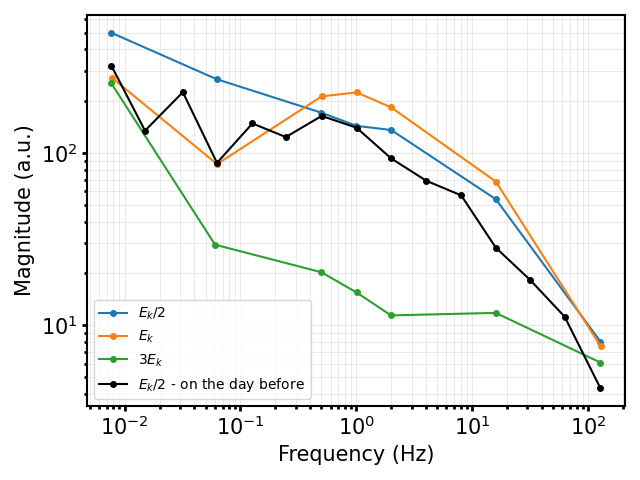

In [11]:
fig, ax = plt.subplots()
colors = []
legends = ["$E_k/2$", "$E_k$", "$3E_k$"]
for i in range(3):
    colors.append(f"C{i}")
    ax = manip[i].plot_bode(fig = fig, ax = ax, marker_color = colors[i], fmt = "o-" ,show_fit = False, leg = legends[i])

ax = controle.plot_bode(fig = fig, ax = ax, marker_color = "black", fmt = "o-" ,show_fit = False, leg = "$E_k/2$ - on the day before")

fig.savefig(f"{manip[0].fig_folder}/all + ctrl.png", dpi = 300)

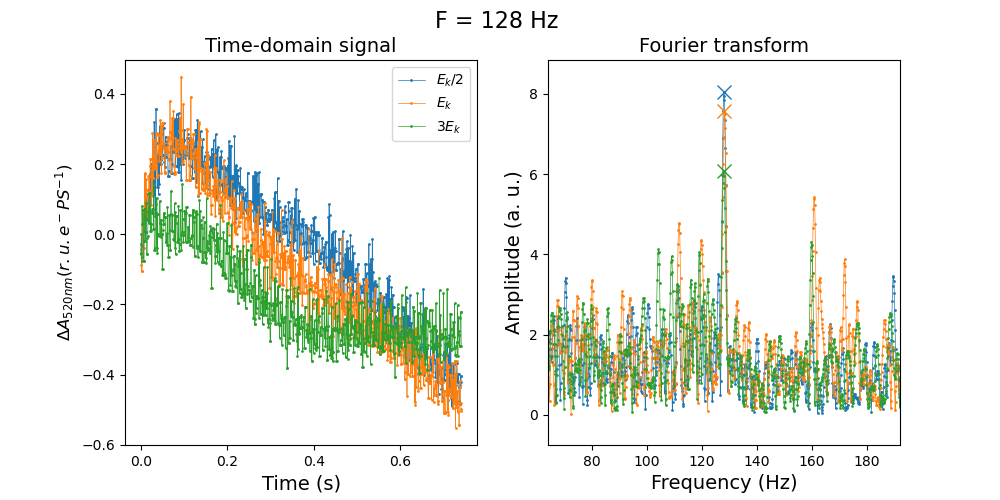

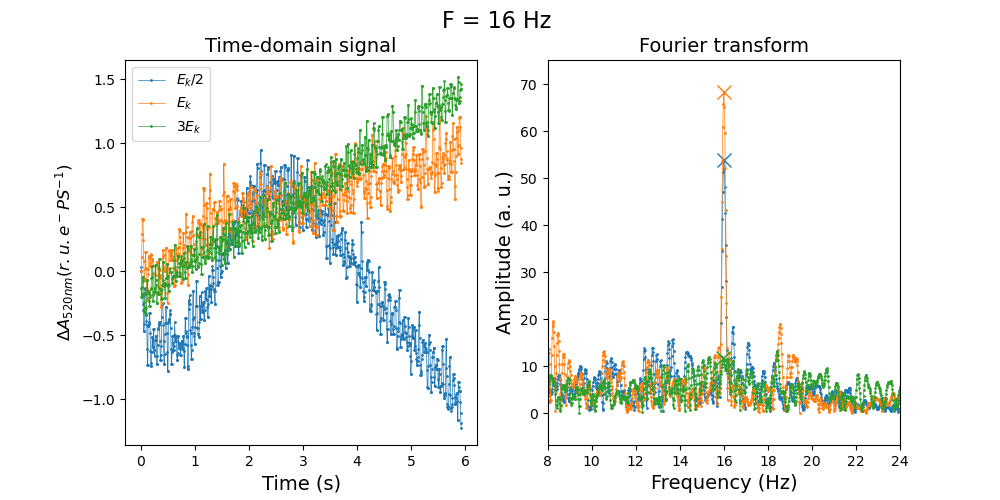

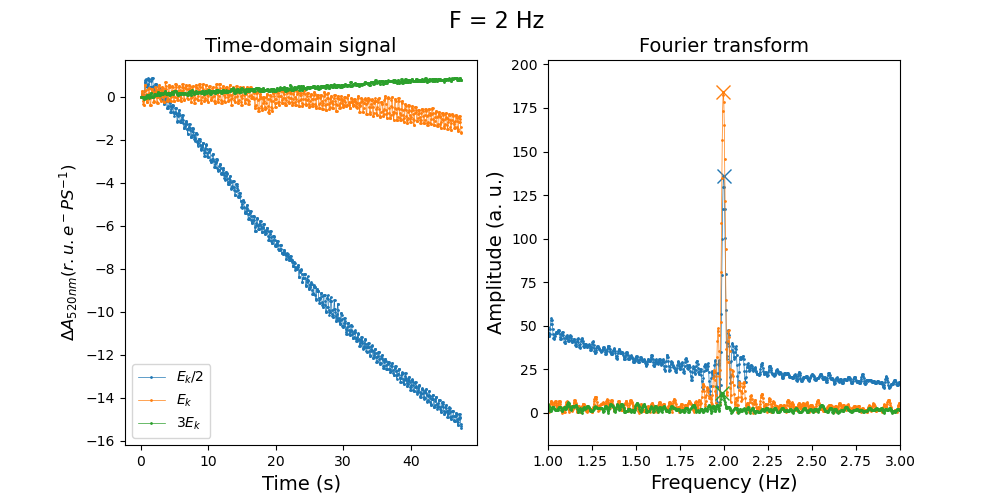

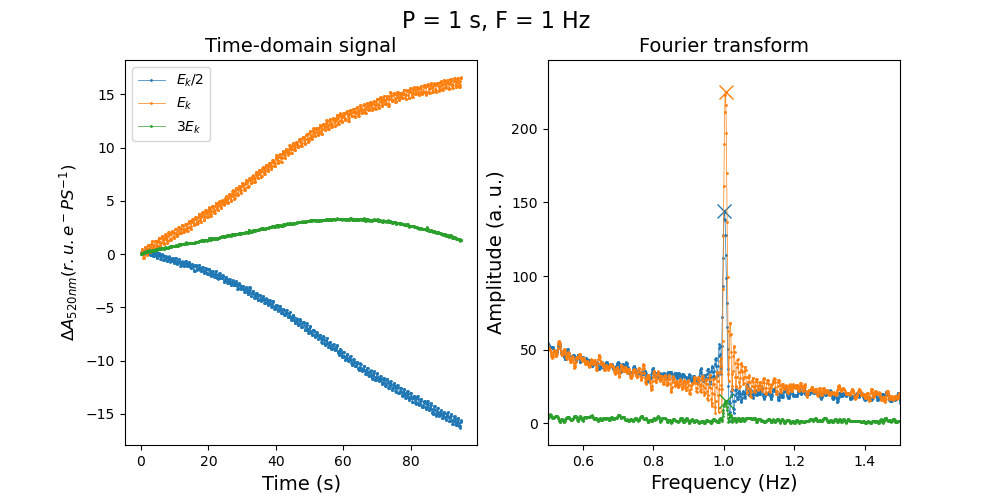

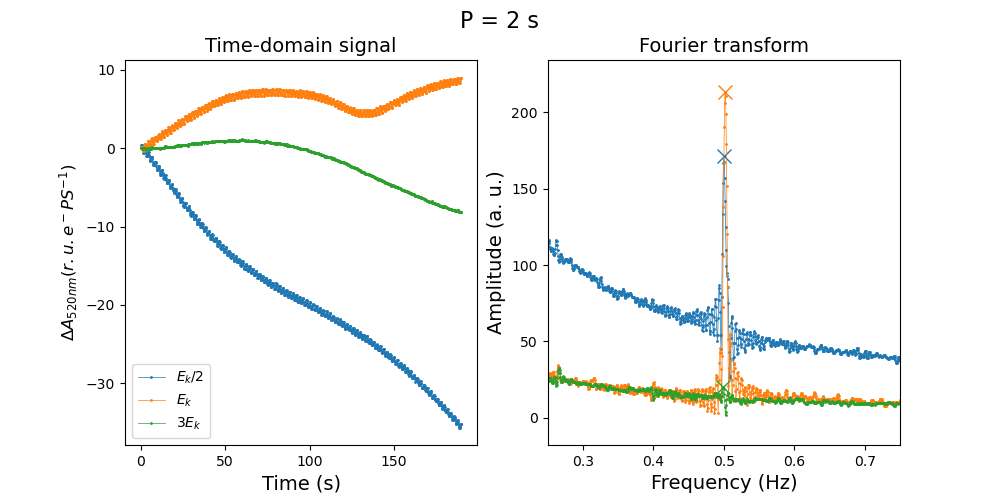

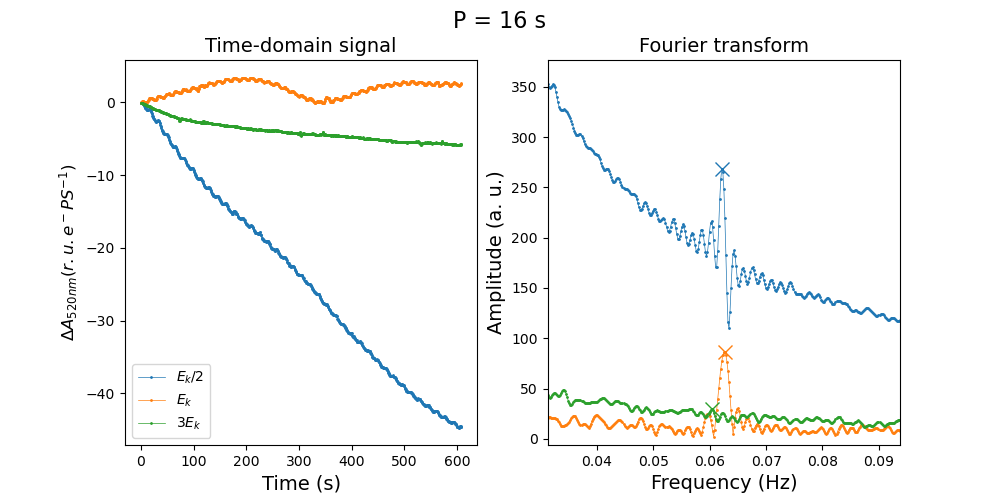

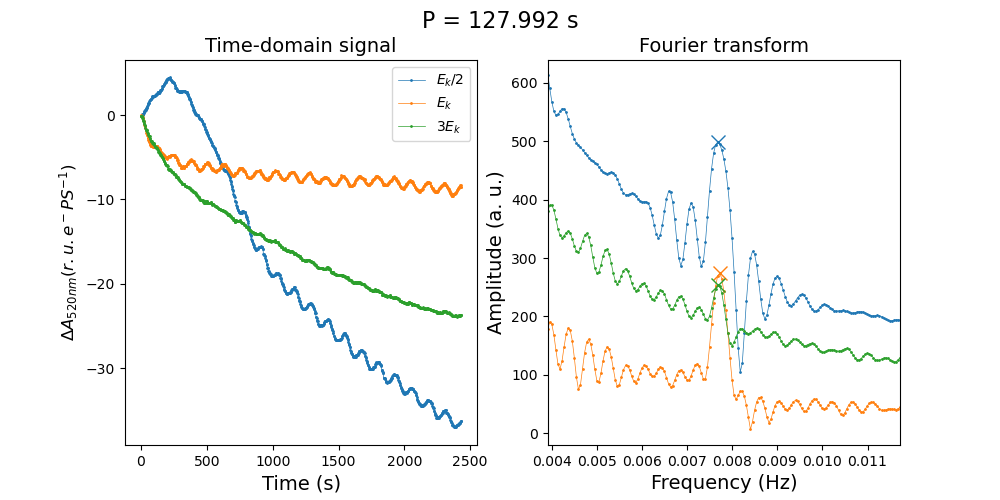

In [39]:
def autoscale_y(ax,margin=0.1):
    """This function rescales the y-axis based on the data that is visible given the current xlim of the axis.
    ax -- a matplotlib axes object
    margin -- the fraction of the total height of the y-data to pad the upper and lower ylims"""

    import numpy as np

    def get_bottom_top(line):
        xd = line.get_xdata()
        yd = line.get_ydata()
        lo,hi = ax.get_xlim()
        y_displayed = yd[((xd>lo) & (xd<hi))]
        h = np.max(y_displayed) - np.min(y_displayed)
        bot = np.min(y_displayed)-margin*h
        top = np.max(y_displayed)+margin*h
        return bot,top

    lines = ax.get_lines()
    bot,top = np.inf, -np.inf

    for line in lines:
        new_bot, new_top = get_bottom_top(line)
        if new_bot < bot: bot = new_bot
        if new_top > top: top = new_top

    ax.set_ylim(bot,top)

for i, k in enumerate(frequency_list):
    fig , ax = plt.subplots(1,2, figsize = (10,5))
    if k < 1:
        fig_title = f"P = {1/frequency_list[i]:n} s"
    elif k == 1:
        fig_title = f"P = {1/frequency_list[i]:n} s, F = {frequency_list[i]} Hz "
    elif k > 1:
        fig_title = f"F = {frequency_list[i]} Hz "
    
    fig.suptitle(fig_title, fontsize = 16)
                    
    ax = manip[0].plot_record_TF(f"E{i+6}", fig = fig, ax = ax, leg = "$E_k/2$", color = "C0")
    ax = manip[1].plot_record_TF(f"E{i+16}", fig = fig, ax = ax, leg = "$E_k$", color = "C1")
    ax = manip[2].plot_record_TF(f"E{i+26}", fig = fig, ax = ax, leg = "$3E_k$", color = "C2")
    
    min = 0.5
    max = 1.5
    
    ax[0].legend()
    ax[1].set_xlim([k*min, k*max])
    autoscale_y(ax[1])
    

    
    fig.savefig(f"{manip[0].fig_folder}/{fig_title}_compare.png")

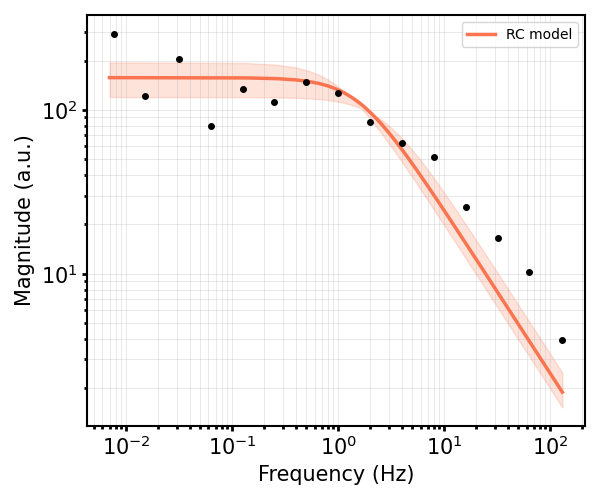

In [42]:
line = 2.5
marker = 4

orange = [250/255, 116/255, 79/255]

popt_RC, pcov_RC, ffit_RC, afit_RC = tools.RC_transf_fit(manip.fund_freq, manip.fund_amp, 0.007, 130, 1000, p0 =  [10, 0.1])


fig, ax = plt.subplots(figsize=(6,5))
fig_title = "Bode plot of the fundamental harmonic"



ax.plot(ffit_RC, afit_RC, linewidth=line, color = orange, label = "RC model")
ax.plot(manip.fund_freq , manip.fund_amp, "o", markersize=marker, color = 'black')

RC_err_neg=[mf.RC_transfer(x,*(popt_RC-2*tools.my_err_vec(x, pcov_RC))) for x in ffit_RC]
RC_err_pos=[mf.RC_transfer(x,*(popt_RC+2*tools.my_err_vec(x, pcov_RC)))for x in ffit_RC]

ax.fill_between(np.linspace(0.007, 130, 1000), RC_err_neg, RC_err_pos, alpha=0.2, color = orange)

ax = tools.bode_plot_axes(ax)

#ax.set_ylim(2e3, 2.5e5)

fig.tight_layout()

fig.savefig(f"{manip.folder}/Figures/bode_replicates.png", dpi=300)

In [45]:
y = mf.RC_transfer(np.asarray(frequency_list), popt_RC[0], popt_RC[1])
y

array([  1.92159272,   3.84232714,   7.67779931,  15.30112349,
        30.17776057,  57.28178945,  96.92632778, 132.61386496,
       149.96230794, 155.47759392, 156.9541848 , 157.3299531 ,
       157.42431763, 157.44793531, 157.45384139])

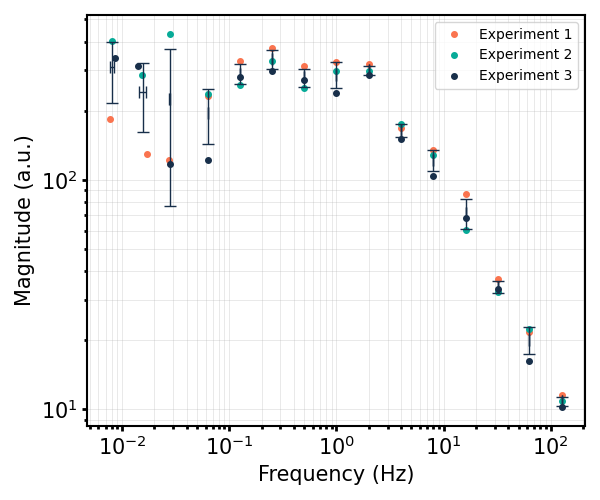

In [ ]:
frequency_list = [0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128][::-1]
names = ["20230720_bode", "20230721_bode", "20230724_bode"]
flash_calib = [402.332, 304.7255953, 338.993692]

line = 2.5
marker = 4

orange = [250/255, 116/255, 79/255]
green = [7/255, 171/255, 152/255]
blue = [24/255, 47/255, 74/255]

colors = [orange, green, blue] 

replicates = []
frequencies = []
amplitudes = []

for i, name in enumerate(names):
    replicates.append(bc.BodeClass(name, "6-20", frequency_list, flash_calib[i], median_filtering_windos_size = 1, padding = True, padding_value = 2000, pic_search_window = 5))
    frequencies.append(replicates[i].fund_freq)
    amplitudes.append(replicates[i].fund_amp)
    
avg_freq = np.mean(frequencies, axis = 0)
avg_amp = np.mean(amplitudes, axis = 0)
std_freq = np.std(frequencies, axis = 0)
std_amp = np.std(amplitudes, axis = 0)

fig, ax = plt.subplots(figsize=(6,5))
fig_title = "Bode plot of the fundamental harmonic"

for i in range(len(names)):
    ax.plot(frequencies[i], amplitudes[i], "o", markersize=marker, color = colors[i], label = f"Experiment {i+1}")
ax.errorbar(avg_freq, avg_amp, xerr=std_freq, fmt ='', linestyle = '', linewidth = 1, yerr=std_amp, capsize=4, color = blue)

ax = tools.bode_plot_axes(ax)

#ax.set_ylim(2e3, 2.5e5)

fig.tight_layout()

fig.savefig(f"{folder}/bode_replicates.png", dpi=300)

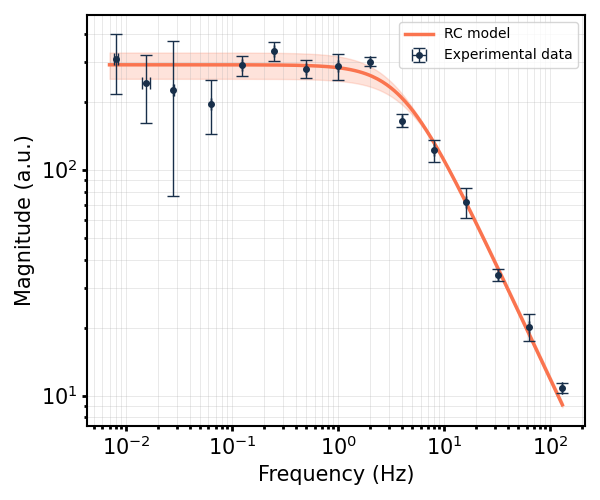

In [23]:
popt_RC, pcov_RC, ffit_RC, afit_RC = tools.RC_transf_fit(avg_freq, avg_amp, 0.007, 130, 1000, p0 =  [10, 0.1], sigma = std_amp)


fig, ax = plt.subplots(figsize=(6,5))
fig_title = "Bode plot of the fundamental harmonic"
ax.plot(ffit_RC, afit_RC, linewidth=line, color = orange, label = "RC model")
ax.errorbar(avg_freq, avg_amp, xerr=std_freq, fmt ='o', markersize = marker, linestyle = '', linewidth = 1, yerr=std_amp, capsize=4, color = blue, label = "Experimental data")

def my_err_vec(x, pcov):
    gradvec=np.array([x,1])
    norm=np.matmul(gradvec.T,np.matmul(pcov,gradvec))
    lambd=np.sqrt(1/norm)
    return np.matmul(pcov,lambd*gradvec)

RC_err_neg=[mf.RC_transfer(x,*(popt_RC-2*my_err_vec(x, pcov_RC))) for x in ffit_RC]
RC_err_pos=[mf.RC_transfer(x,*(popt_RC+2*my_err_vec(x, pcov_RC)))for x in ffit_RC]

ax.fill_between(np.linspace(0.007, 130, 1000), RC_err_neg, RC_err_pos, alpha=0.2, color = orange)

ax = tools.bode_plot_axes(ax)
#ax.set_ylim(2e3, 1.8e5)

fig.tight_layout()
fig.savefig(f"{folder}/bode_model.png", dpi=300)

In [24]:
old_frequency_list = [0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32]
old_recs = "37, 36, 35, 34, 33, 32, 31, 11, 41, 42, 45, 49, 51"
old_bode = bc.BodeClass("20230519_WT4A_ECS_bode", old_recs, old_frequency_list, 496.27877,
                        median_filtering_windos_size = 1, padding = True, padding_value = 2000, pic_search_window = 5)


In [25]:
old_bode

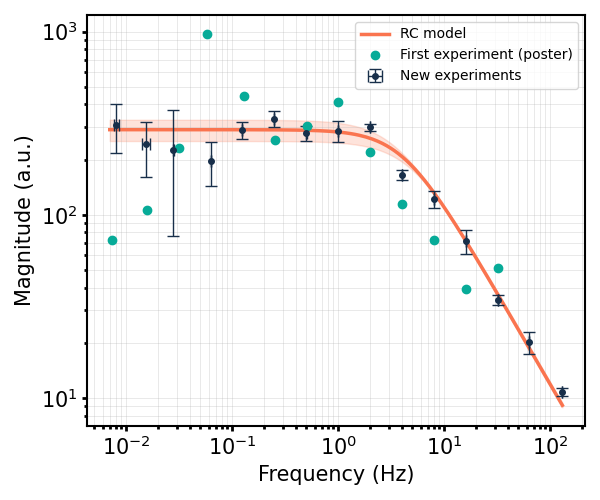

In [26]:




popt_RC, pcov_RC, ffit_RC, afit_RC = tools.RC_transf_fit(avg_freq, avg_amp, 0.007, 130, 1000, p0 =  [10, 0.1], sigma = std_amp)


fig, ax = plt.subplots(figsize=(6,5))
fig_title = "Bode plot of the fundamental harmonic"
ax.plot(ffit_RC, afit_RC, linewidth=line, color = orange, label = "RC model")
ax.errorbar(avg_freq, avg_amp, xerr=std_freq, fmt ='o', markersize = marker, linestyle = '', linewidth = 1, yerr=std_amp, capsize=4, color = blue, label = "New experiments")
ax.plot(old_bode.fund_freq, old_bode.fund_amp, 'o', markersize = 6, linewidth = 1, color = green, label = "First experiment (poster)")

RC_err_neg=[mf.RC_transfer(x,*(popt_RC-2*tools.my_err_vec(x, pcov_RC))) for x in ffit_RC]
RC_err_pos=[mf.RC_transfer(x,*(popt_RC+2*tools.my_err_vec(x, pcov_RC)))for x in ffit_RC]

ax.fill_between(np.linspace(0.007, 130, 1000), RC_err_neg, RC_err_pos, alpha=0.2, color = orange)

ax = tools.bode_plot_axes(ax)
#ax.set_ylim(2e3, 1.8e5)

fig.tight_layout()
fig.savefig(f"{folder}/bode_model_compare.png", dpi=300)

In [27]:
my_err_vec(1, pcov_RC)

array([ 1.93759035e+01, -1.16101863e-05])

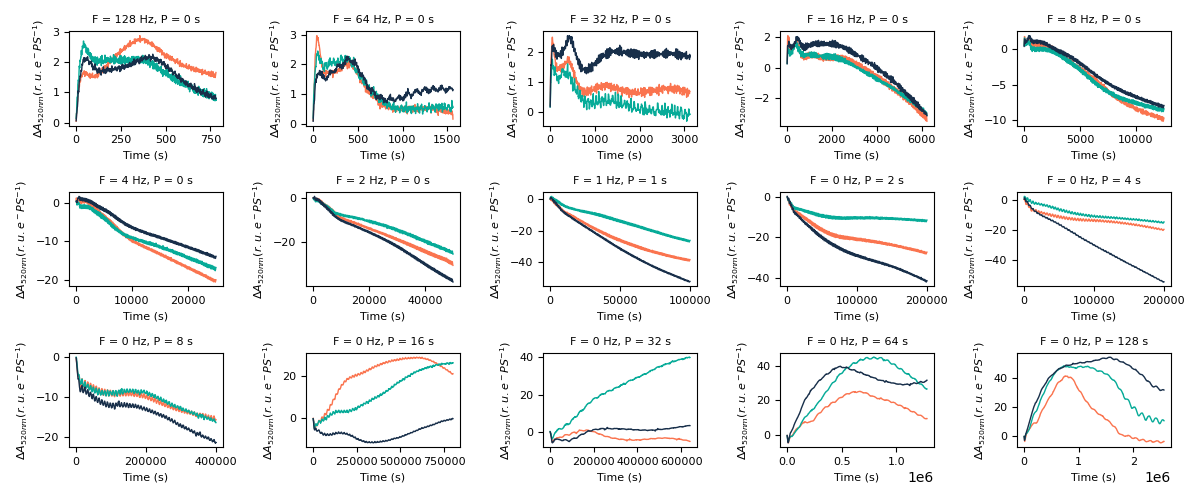

In [28]:
fig, ax = plt.subplots(3,5,figsize=(12,5))
ax = ax.flatten()
aux = 0
for j, frequency in enumerate(frequency_list):
    for i, name in enumerate(names):
        ax[aux].plot(replicates[i].bode_times[j], replicates[i].bode_data[j], linewidth=1, color = colors[i], label = f"Experiment {i+1}")
    ax[aux].set_title(f"F = {frequency:.0f} Hz, P = {1/frequency:.0f} s", fontsize = 8)
    ax[aux].set_xlabel("Time (s)", fontsize = 8)
    ax[aux].set_ylabel("$ΔA_{ 520 nm} (r. u. e^- PS^{-1})$", fontsize = 8)
    ax[aux].tick_params(axis='both', which='major', labelsize=8)
    aux = aux + 1
fig.tight_layout()

fig.savefig(f"{folder}/bode_time.png", dpi=300)

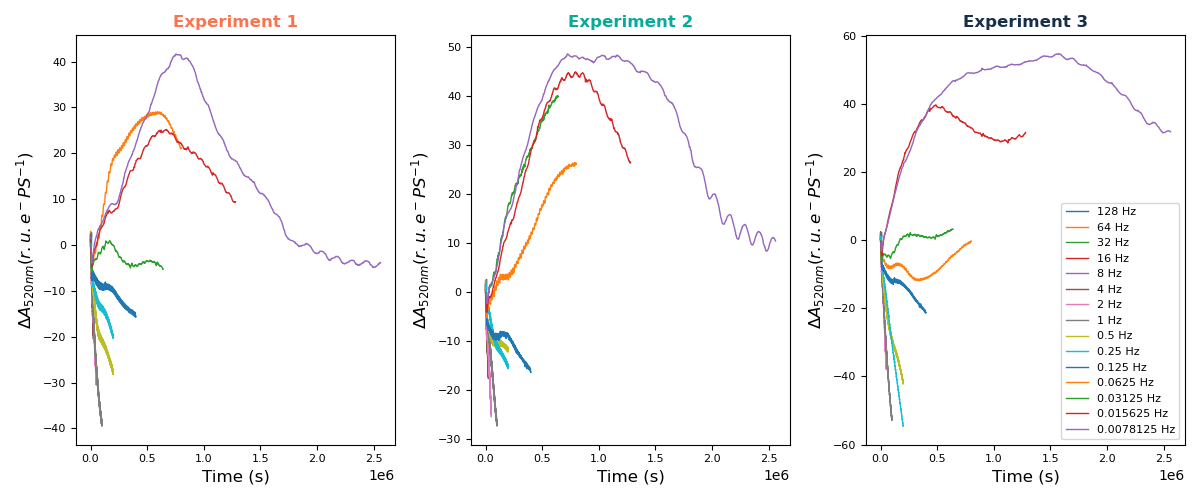

In [29]:
fig, ax = plt.subplots(1,3,figsize=(12,5))
ax = ax.flatten()
for i, name in enumerate(names):
    for j, frequency in enumerate(frequency_list):
        ax[i].plot(replicates[i].bode_times[j], replicates[i].bode_data[j], linewidth=1, label = f"{frequency} Hz")
    ax[i].set_title(f"Experiment {i+1}", fontsize = 12, color = colors[i], fontweight = "bold")
    ax[i].set_xlabel("Time (s)", fontsize = 12)
    ax[i].set_ylabel("$ΔA_{520 nm} (r. u. e^- PS^{-1})$", fontsize = 12)
    ax[i].tick_params(axis='both', which='major', labelsize=8)
ax[2].legend(fontsize = 8)
fig.tight_layout()

fig.savefig(f"{folder}/bode_derive.png", dpi=300)